In [1]:
from collections import defaultdict
from sentence_transformers import util
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sqlalchemy import func, literal_column
import pandas as pd
from database import SessionLocal, engine
from sqlalchemy.orm import Session
from models import Torrent, TorrentFile, Video
from vector_index import get_document_text_for_video, get_model, query_preamble
# from vector_index import get_model, rerank, get_document_text_for_video, get_preamble

db: Session = SessionLocal()

def query_with_tags(positive_tags, negative_tags=None, mode="positive"):
    if mode == "positive":
        # Any video that has at least one positive tag
        tag_count = len(positive_tags)
        query = (
            db.query(Video)
            .join(func.json_each(Video.torrent_tags), literal_column("1"))
            .filter(
                literal_column("json_each.value").in_(positive_tags)
            )
            .group_by(Video.id)
            .having(func.count(func.distinct(literal_column("json_each.value"))) == tag_count)
    
        )

    elif mode == "negative":
        # First: subquery to find videos with any positive tag
        tag_count = len(positive_tags)
        positive_subq = (
            db.query(Video.id)
            .join(func.json_each(Video.torrent_tags), literal_column("1"))
            .filter(
                literal_column("json_each.value").in_(positive_tags)
            )
            .group_by(Video.id)
            .having(func.count(func.distinct(literal_column("json_each.value"))) == tag_count)
            .subquery()
        )

        # Then: select videos with any negative tag, excluding those that have positive tags
        query = (
            db.query(Video)
            .join(func.json_each(Video.torrent_tags), literal_column("1"))
            .filter(
                literal_column("json_each.value").in_(negative_tags),
                ~Video.id.in_(positive_subq)
            )
            .group_by(Video.id)
        )

    else:
        raise ValueError("mode must be 'positive' or 'negative'")

    return query

c:\Users\madsl\.virtualenvs\videobackend-Kr5Og4d_\Lib\site-packages\pydantic\_internal\_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'orm_mode' has been renamed to 'from_attributes'
  warnings.warn(message, UserWarning)


Torch information:
11.8
True
1
NVIDIA GeForce RTX 3080


In [2]:
embedding_cache = {}



In [3]:

embed_query = query_preamble + "brunette hair and blonde"
tags_pos = ["brunette"]
tags_neg = ["blonde"]

# Positive test pool
query = query_with_tags(tags_pos)
dfpos = pd.read_sql_query(query.statement, con=engine)
videos = query.all()
positive_set = []
for video in videos:
    text = get_document_text_for_video(video)
    positive_set.append({"video":video, "text":text})

# Negative test pool
query = query_with_tags(tags_pos, tags_neg, mode="negative")
defneg = pd.read_sql_query(query.statement, con=engine)
videos = query.all()
negative_set = []
for video in videos:
    text = get_document_text_for_video(video)
    negative_set.append({"video":video, "text":text})

triplets = []
random.seed(42)
# for query in queries:
# sampled_pos = random.sample(positive_set, k=min(5, len(positive_set)))
for pos in positive_set:
    sampled_negs = random.sample(negative_set, k=min(5, len(negative_set)))
    for neg in sampled_negs:
        
        triplets.append({
            "query": embed_query,
            "positive": pos["text"],
            "negative": neg["text"]
        })

unique_set = set()
deduped_triplets = []

for triplet in triplets:
    # Turn the triplet into a tuple of strings for hashing
    key = (triplet['query'], triplet['positive'], triplet['negative'])
    
    if key not in unique_set:
        unique_set.add(key)
        deduped_triplets.append(triplet)
triplets = deduped_triplets

db.close()

C:\Users\madsl\AppData\Local\Temp\ipykernel_14648\1322774977.py:51: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  ~Video.id.in_(positive_subq)


Processing triplets: 100%|██████████| 1210/1210 [00:21<00:00, 55.70it/s]
C:\Users\madsl\AppData\Local\Temp\ipykernel_14648\2481448772.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=query_names, palette="viridis")


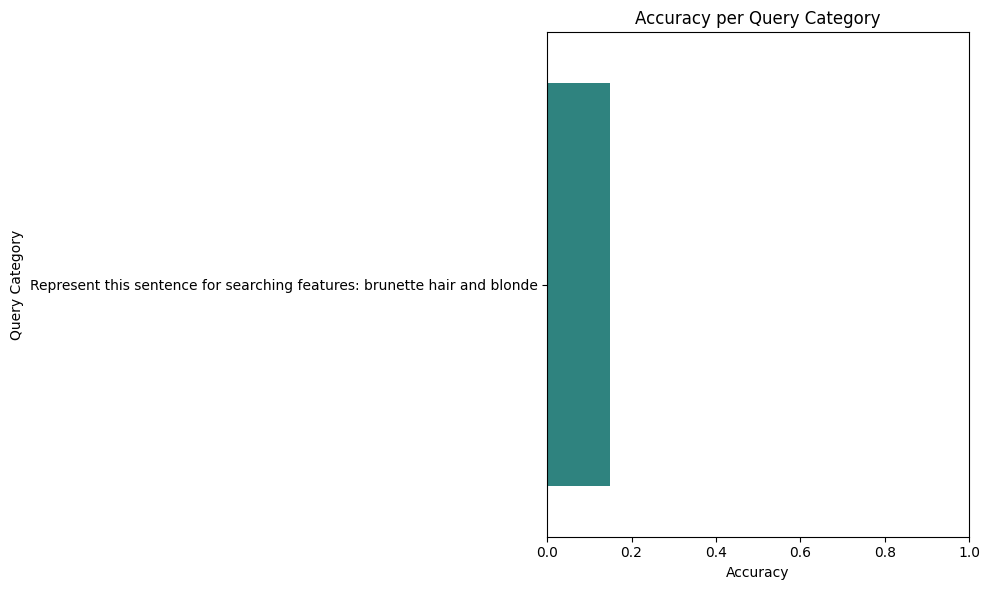

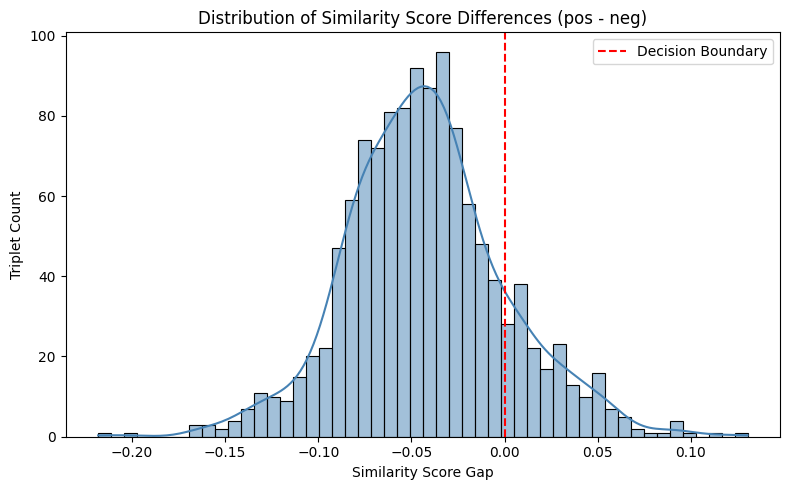

In [4]:
from tqdm import tqdm


def get_embedding(text, is_query=False):
    if text not in embedding_cache:
        embedding_cache[text] = get_model().encode(text, normalize_embeddings=True)
    return embedding_cache[text]

query_scores = defaultdict(lambda: {"correct": 0, "total": 0})
score_diffs = []
for triplet in tqdm(triplets, desc="Processing triplets"):
    query = triplet['query']
    q_emb = get_embedding('Represent this sentence for searching features: ' + triplet['query'], is_query=True)
    p_emb = get_embedding("Represent this sentence for semantic similarity:\n" + triplet['positive'])
    n_emb = get_embedding("Represent this sentence for semantic similarity:\n" + triplet['negative'])
    
    sim_p = util.cos_sim(q_emb, p_emb).item()
    sim_n = util.cos_sim(q_emb, n_emb).item()
    
    if sim_p > sim_n:
        query_scores[query]["correct"] += 1
    query_scores[query]["total"] += 1

    score_diffs.append(sim_p - sim_n)

query_names = []
accuracies = []

for q, scores in query_scores.items():
    acc = scores["correct"] / scores["total"]
    query_names.append(q)
    accuracies.append(acc)

# Sort by accuracy
sorted_indices = sorted(range(len(query_names)), key=lambda i: accuracies[i], reverse=True)
query_names = [query_names[i] for i in sorted_indices]
accuracies = [accuracies[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=query_names, palette="viridis")
plt.xlabel("Accuracy")
plt.ylabel("Query Category")
plt.title("Accuracy per Query Category")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(score_diffs, bins=50, kde=True, color="steelblue")
plt.title("Distribution of Similarity Score Differences (pos - neg)")
plt.xlabel("Similarity Score Gap")
plt.ylabel("Triplet Count")
plt.axvline(x=0, color='red', linestyle='--', label='Decision Boundary')
plt.legend()
plt.tight_layout()
plt.show()